# Exploring Slot Machine Data

In [421]:
# 필요한 패키지 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st

sns.set(style="darkgrid", font_scale=2)

%matplotlib inline

In [4]:
labels = ['10', 'J', 'Q', 'K', 'A', 'Ca', 'Co', 'D', 'Cr', 'W', 'R']

In [5]:
# csv 파일 불러오기

slot_result = pd.read_csv('../data/slot_machine/platinum_csv/pl_all.csv')
slot_result.head()

,img,classname
0,platinum_0_0.jpg,Ca
1,platinum_0_1.jpg,A
2,platinum_0_2.jpg,Q
3,platinum_0_3.jpg,W
4,platinum_0_4.jpg,A


In [6]:
# 각 칸의 결과마다 game, row, col column 생성

slot_result_game = [int(i_name.split('_')[1]) for n, i_name in enumerate(slot_result['img'])]
slot_result_row = [int(i_name.split('_')[2].split('.')[0]) % 3 + 1 for n, i_name in enumerate(slot_result['img'])]
slot_result_col = [int(i_name.split('_')[2].split('.')[0]) // 3 + 1 for n, i_name in enumerate(slot_result['img'])]

In [7]:
slot_result['game'] = slot_result_game
slot_result['row'] = slot_result_row
slot_result['col'] = slot_result_col

slot_result.head(15)

,img,classname,game,row,col
0,platinum_0_0.jpg,Ca,0,1,1
1,platinum_0_1.jpg,A,0,2,1
2,platinum_0_2.jpg,Q,0,3,1
3,platinum_0_3.jpg,W,0,1,2
4,platinum_0_4.jpg,A,0,2,2
5,platinum_0_5.jpg,A,0,3,2
6,platinum_0_6.jpg,10,0,1,3
7,platinum_0_7.jpg,Cr,0,2,3
8,platinum_0_8.jpg,Co,0,3,3
9,platinum_0_9.jpg,10,0,1,4


In [8]:
tmp = []
slot_result_per_game = []
for n, x in enumerate(slot_result['classname']):
    tmp.append(x)
    if (n+1) % 15 == 0:
        slot_result_per_game.append(tmp)
        tmp = []

## 1. 각 Symbol의 출현 빈도 확인

In [9]:
# 각 Symbol의 출현 확률의 구체적인 수치

slot_result['classname'].value_counts() / len(slot_result) * 100

Q     13.236667
10    12.553333
K     12.073333
A     11.506667
J      9.543333
Ca     9.520000
Cr     8.760000
D      8.026667
Co     7.576667
R      4.040000
W      3.163333
Name: classname, dtype: float64

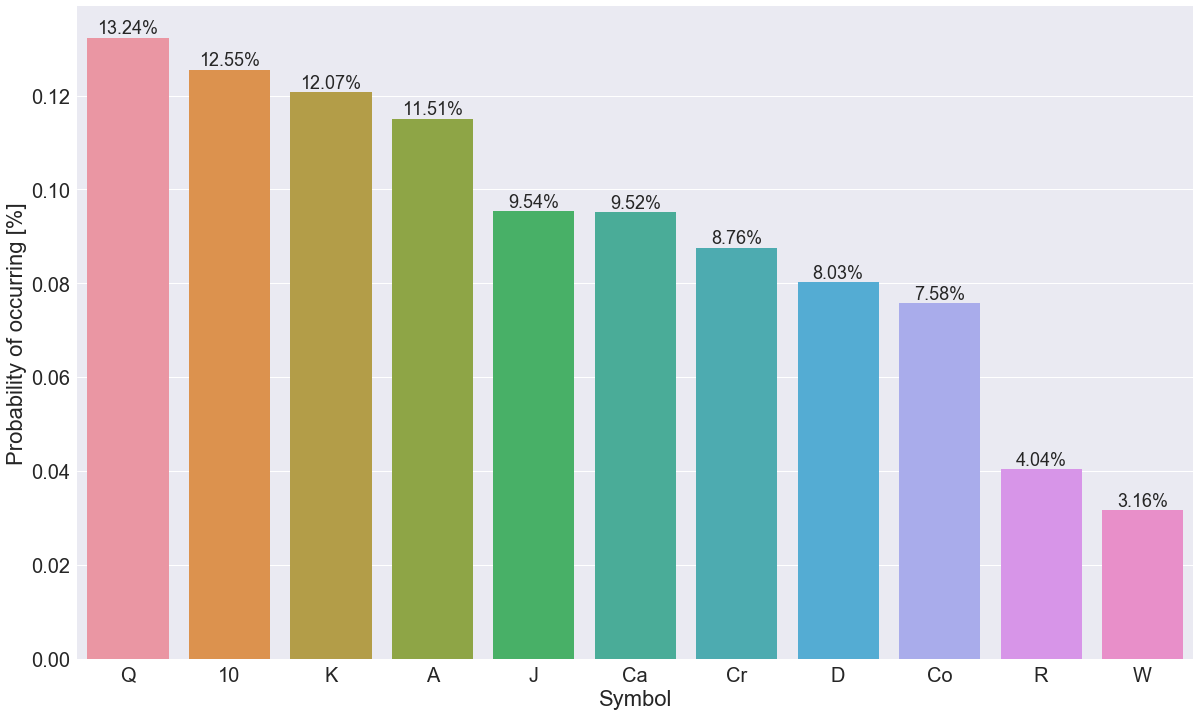

In [426]:
# 각 Symbol의 출현 확률 시각화

plt.figure(figsize=(20,12))
ax = sns.barplot(x=slot_result['classname'].value_counts().index, y=slot_result['classname'].value_counts() / len(slot_result))
plt.xlabel("Symbol")
plt.ylabel("Probability of occurring [%]")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(y*100), (x.mean(), y), ha='center', va='bottom', fontsize=18) # set the alignment of the text

plt.show()

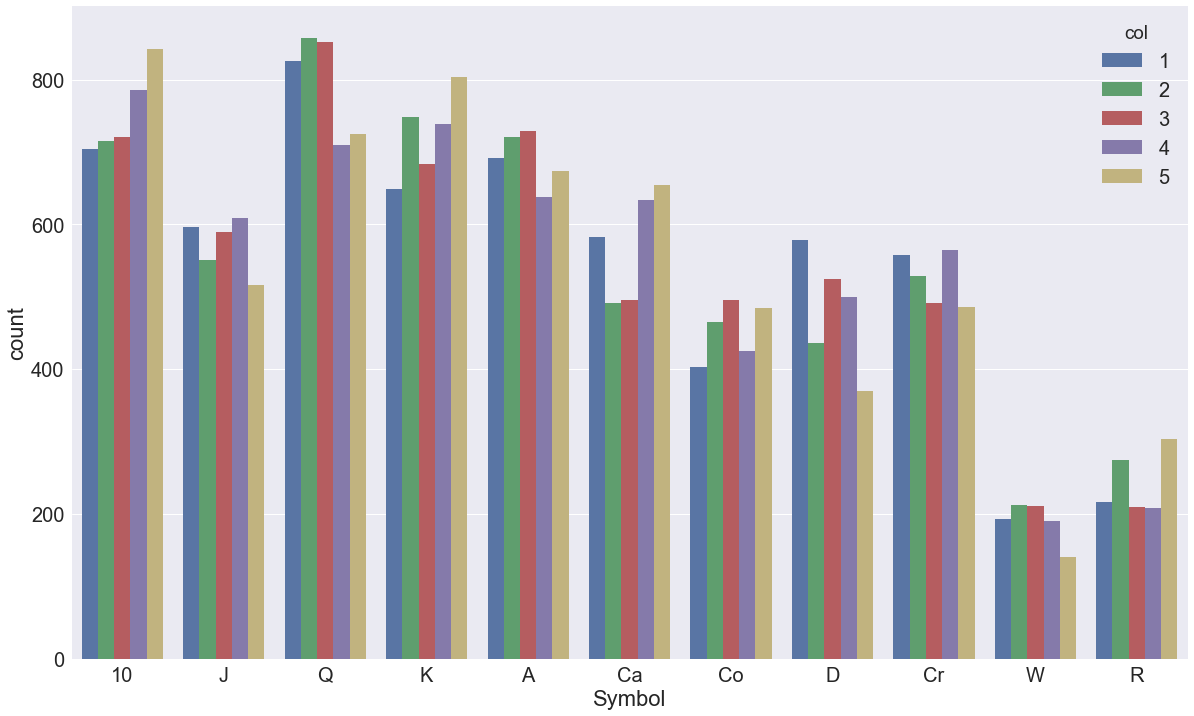

In [427]:
# 각 reel별 출현 횟수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='classname', data=slot_result, hue='col', order=labels)
plt.xlabel("Symbol")
plt.show()

## 2. Simulation 데이터 생성
각 15개의 칸이 위의 각 Symbol의 출현 확률을 가지고 완전히 독립적으로 작동한다는 가정 하에 2000번의 Simulation 데이터를 생성하고, 게임 모델을 보완하여 최대한 실제 게임과 가깝게 만들기 위해 실제 게임과의 차이를 확인합니다.

In [483]:
'''
# Baseline Model

2000번의 실제 게임 데이터를 기반으로 각 Symbol의 출현 빈도 설정

# Q   : 13.5 %
# 10  : 12.5 %
# K   : 12 %
# A   : 11.5 %
# J   : 9.5 %
# Ca  : 9.5 %
# Cr  : 9 %
# D   : 8 %
# Co  : 7.5 %
# R   : 4 %
# W   : 3 %
'''

# numpy의 randint를 통해 출현 확률을 기반으로 Symbol을 Return하는 함수

def getPlatinumSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 27:
        return 'Q'
    elif i <= 52 and i > 27:
        return '10'
    elif i <= 76 and i > 52:
        return 'K'
    elif i <= 99 and i > 76:
        return 'A'
    elif i <= 118 and i > 99:
        return 'J'
    elif i <= 137 and i > 118:
        return 'Ca'
    elif i <= 155 and i > 137:
        return 'Cr'
    elif i <= 171 and i > 155:
        return 'D'
    elif i <= 186 and i > 171:
        return 'Co'
    elif i <= 192 and i > 186:
        return 'W'
    elif i > 192:
        return 'R'

# 1회의 Spin 실행을 구현한 함수

def spin_platinum():
    game = []
    start = 1
    end = 201
    for i in range(15):
        if game.count('R') >= 9:
            end = 193
        game.append(getPlatinumSymbol(start, end))
    return game

# 플레이 횟수, 배팅 금액을 받아와서 게임을 플레이
def playPlatinum(n, bet):
    bpl = bet / 30
    pay_list = []
    while(n):
        game = spin_platinum()
        pay_list.append(calPlatinumPayline(game, bpl))
        n -= 1
    return pay_list

In [272]:
'''
# ColType 개량 버전
'''


def getPlatinumColType(i):
    if i==0:
        j = np.random.randint(1, 201)
        if j <= 109:
            return '3'
        elif j <= 151 and j > 109:
            return '2-1'
        elif j <= 169 and j > 151:
            return '2-2'
        elif j <= 186 and j > 169:
            return '2-3'
        elif j > 186:
            return '1'
    if i==1:
        j = np.random.randint(1, 201)
        if j <= 88:
            return '3'
        elif j <= 127 and j > 88:
            return '2-1'
        elif j <= 138 and j > 127:
            return '2-2'
        elif j <= 183 and j > 138:
            return '2-3'
        elif j > 183:
            return '1'
    if i==2:
        j = np.random.randint(1, 201)
        if j <= 93:
            return '3'
        elif j <= 125 and j > 93:
            return '2-1'
        elif j <= 137 and j > 125:
            return '2-2'
        elif j <= 176 and j > 137:
            return '2-3'
        elif j > 176:
            return '1'
    if i==3:
        j = np.random.randint(1, 201)
        if j <= 110:
            return '3'
        elif j <= 130 and j > 110:
            return '2-1'
        elif j <= 149 and j > 130:
            return '2-2'
        elif j <= 192 and j > 149:
            return '2-3'
        elif j > 192:
            return '1'
    if i==4:
        j = np.random.randint(1, 201)
        if j <= 78:
            return '3'
        elif j <= 127 and j > 78:
            return '2-1'
        elif j <= 134 and j > 127:
            return '2-2'
        elif j <= 151 and j > 134:
            return '2-3'
        elif j > 151:
            return '1'

def getPlatinumSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 27:
        return 'Q'
    elif i <= 52 and i > 27:
        return '10'
    elif i <= 76 and i > 52:
        return 'K'
    elif i <= 99 and i > 76:
        return 'A'
    elif i <= 118 and i > 99:
        return 'J'
    elif i <= 137 and i > 118:
        return 'Ca'
    elif i <= 155 and i > 137:
        return 'Cr'
    elif i <= 171 and i > 155:
        return 'D'
    elif i <= 186 and i > 171:
        return 'Co'
    elif i <= 192 and i > 186:
        return 'W'
    elif i > 192:
        return 'R'

def spin_platinum():
    game = []
    start = 1
    end = 201
    for i in range(5):
        tmp = []
        if game.count('R') >= 9:
            end = 193
        col_type = getPlatinumColType(i)
        if col_type == '3':
            for i in range(3):
                tmp.append(getPlatinumSymbol(start, end))
        elif col_type == '2-1':
            tmp.extend([getPlatinumSymbol(start, end)]*2)
            tmp.append(getPlatinumSymbol(start, end))
        elif col_type == '2-2':
            tmp.extend([getPlatinumSymbol(start, end)]*2)
            tmp.append(getPlatinumSymbol(start, end))
            tmp[2], tmp[1] = tmp[1], tmp[2]
        elif col_type == '2-3':
            tmp.append(getPlatinumSymbol(start, end))
            tmp.extend([getPlatinumSymbol(start, end)]*2)
        elif col_type == '1':
            tmp.extend([getPlatinumSymbol(start, end)]*3)
        game.extend(tmp)
    return game

In [576]:
'''
# 확률 가중치 개량 버전
'''


def getPlatinumColType(i):
    if i==0:
        j = np.random.randint(1, 201)
        if j <= 109:
            return '3'
        elif j <= 151 and j > 109:
            return '2-1'
        elif j <= 169 and j > 151:
            return '2-2'
        elif j <= 186 and j > 169:
            return '2-3'
        elif j > 186:
            return '1'
    if i==1:
        j = np.random.randint(1, 201)
        if j <= 88:
            return '3'
        elif j <= 127 and j > 88:
            return '2-1'
        elif j <= 138 and j > 127:
            return '2-2'
        elif j <= 183 and j > 138:
            return '2-3'
        elif j > 183:
            return '1'
    if i==2:
        j = np.random.randint(1, 201)
        if j <= 93:
            return '3'
        elif j <= 125 and j > 93:
            return '2-1'
        elif j <= 137 and j > 125:
            return '2-2'
        elif j <= 176 and j > 137:
            return '2-3'
        elif j > 176:
            return '1'
    if i==3:
        j = np.random.randint(1, 201)
        if j <= 110:
            return '3'
        elif j <= 130 and j > 110:
            return '2-1'
        elif j <= 149 and j > 130:
            return '2-2'
        elif j <= 192 and j > 149:
            return '2-3'
        elif j > 192:
            return '1'
    if i==4:
        j = np.random.randint(1, 201)
        if j <= 78:
            return '3'
        elif j <= 127 and j > 78:
            return '2-1'
        elif j <= 134 and j > 127:
            return '2-2'
        elif j <= 151 and j > 134:
            return '2-3'
        elif j > 151:
            return '1'

def getPlatinumSymbol(probs, r_full=0):
    if r_full:
        i = np.random.randint(1, sum(probs[:10])+1)
    else:
        i = np.random.randint(1, sum(probs)+1)
    if i <= sum(probs[:1]):
        return 'Q'
    elif i <= sum(probs[:2]) and i > sum(probs[:1]):
        return '10'
    elif i <= sum(probs[:3]) and i > sum(probs[:2]):
        return 'K'
    elif i <= sum(probs[:4]) and i > sum(probs[:3]):
        return 'A'
    elif i <= sum(probs[:5]) and i > sum(probs[:4]):
        return 'J'
    elif i <= sum(probs[:6]) and i > sum(probs[:5]):
        return 'Ca'
    elif i <= sum(probs[:7]) and i > sum(probs[:6]):
        return 'Cr'
    elif i <= sum(probs[:8]) and i > sum(probs[:7]):
        return 'D'
    elif i <= sum(probs[:9]) and i > sum(probs[:8]):
        return 'Co'
    elif i <= sum(probs[:10]) and i > sum(probs[:9]):
        return 'W'
    elif i > sum(probs[:10]):
        return 'R'

def getWeightedProbability(game):
    weight = [27, 25, 24, 23, 19, 19, 18, 16, 15, 8, 6]
    switch = [0] * 11
    unique_list = list(set(game))
    for n, s in enumerate(labels):
        if s in unique_list:
            switch[n] = 2
        if s != 'R' and game.count(s) >= 6:
            switch[n] = 5
    probs = [w*(switch[n]+1) for n, w in enumerate(weight)]
    return probs

def spin_platinum():
    game = []
    r_full = 0
    for i in range(5):
        probs = getWeightedProbability(game)
        tmp = []
        if game.count('R') >= 9:
            r_full = 1
        col_type = getPlatinumColType(i)
        if col_type == '3':
            for i in range(3):
                tmp.append(getPlatinumSymbol(probs, r_full))
        elif col_type == '2-1':
            tmp.extend([getPlatinumSymbol(probs, r_full)]*2)
            tmp.append(getPlatinumSymbol(probs, r_full))
        elif col_type == '2-2':
            tmp.extend([getPlatinumSymbol(probs, r_full)]*2)
            tmp.append(getPlatinumSymbol(probs, r_full))
            tmp[2], tmp[1] = tmp[1], tmp[2]
        elif col_type == '2-3':
            tmp.append(getPlatinumSymbol(probs, r_full))
            tmp.extend([getPlatinumSymbol(probs, r_full)]*2)
        elif col_type == '1':
            tmp.extend([getPlatinumSymbol(probs, r_full)]*3)
        game.extend(tmp)
    return game

In [577]:
# 실행 결과를 담을 list
simul_result_per_game = []

# 2000번의 게임을 실행
for i in range(2000):
    simul_result_per_game.append(spin_platinum())

In [578]:
# 실제 게임 플레이 DataFrame을 불러와서 가상 게임플레이 데이터로 변경

simul_result = slot_result[['classname', 'game', 'row', 'col']]

simul_classname = []

for game in simul_result_per_game:
    for x in game:
        simul_classname.append(x)

simul_result['classname'] = simul_classname

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [579]:
simul_result.head()

,classname,game,row,col
0,Q,0,1,1
1,Ca,0,2,1
2,J,0,3,1
3,Q,0,1,2
4,Q,0,2,2


## 3-1. 비교 - RICHHITS

In [558]:
# 실제 게임의 게임당 RICHHITS 출현 횟수를 담은 list를 생성

real_rich_count = []
for game in slot_result_per_game:
    real_rich_count.append(game.count('R'))

In [559]:
# 실제 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(real_rich_count).value_counts()

0    1242
1     434
2     223
3      77
4      19
5       5
dtype: int64

In [560]:
# 가상 게임의 게임당 RICHHITS 출현 횟수를 담은 list를 생성

simul_rich_count = []
for game in simul_result_per_game:
    simul_rich_count.append(game.count('R'))

In [561]:
# 가상 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(simul_rich_count).value_counts()

0    1608
1     238
2      89
3      44
4      14
6       4
5       3
dtype: int64

In [562]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_rich = pd.DataFrame(columns=['rich_count', 'hue'])
df_rich['rich_count'] = real_rich_count + simul_rich_count
df_rich['hue'] = ['real'] * 2000 + ['simul'] * 2000

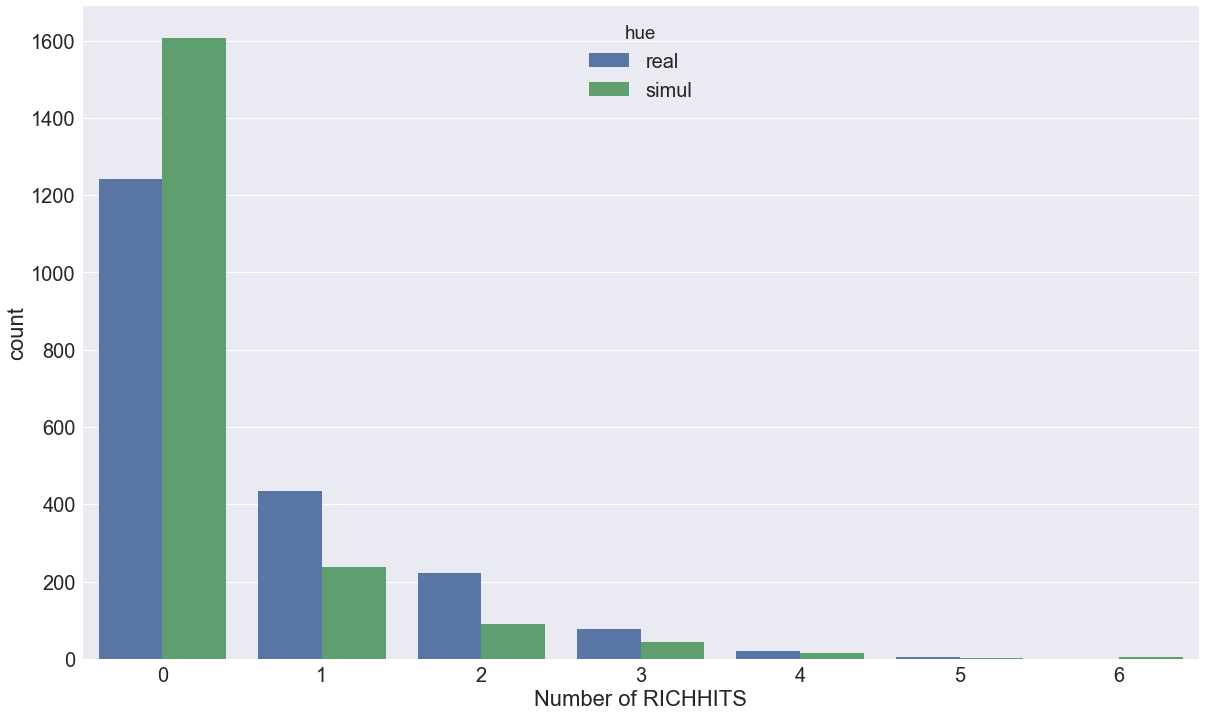

In [563]:
# 실제, 가상의 각 게임당 RICHHITS 갯수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='rich_count', data=df_rich, hue='hue')
plt.xlabel("Number of RICHHITS")
plt.show()

시각화 결과 시뮬레이션 데이터와 실제 데이터 사이에 어느정도 차이가 있는 것처럼 보인다는 것을 알 수 있습니다. 이 차이가 유의한지 여부를 확인하기 위해 카이제곱 적합도 검정을 사용합니다. 카이제곱 적합도 검정은 범주형 확률분포의 모수 $\mu=(\mu_1, \ldots, \mu_K)$에 대한 가설을 조사하는 검정 방법입니다. 원래 범주형 값 $k$가 나와야 할 횟수의 기댓값 $m_k$와 실제 나온 횟수 $x_k$의 차이를 이용하여 다음처럼 검정통계량을 구합니다.

$$
\begin{align}
\sum_{k=1}^K \dfrac{(x_k - m_k)^2}{m_k}
\end{align}
$$

###### Hypothesis test 1

귀무 가설과 대립 가설은 아래와 같습니다.

* H<sub>0</sub>: 시뮬레이션 결과는 실제 결과와 같다
* H<sub>1</sub>: 시뮬레이션 결과는 실제 결과와 다르다

테스트는 5% 유의 수준에서 수행되었습니다.

In [564]:
length = min(len(pd.Series(real_rich_count).value_counts()), len(pd.Series(simul_rich_count).value_counts()))

f_obs = list(pd.Series(real_rich_count).value_counts())[:length]
f_exp = list(pd.Series(simul_rich_count).value_counts())[:length]

st.chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=473.2562581296144, pvalue=4.719790670226637e-100)

p-value가 1.3912538539206486e-32로 유의수준 0.05보다 매우 작은 값이므로 기무가설을 기각하고 대립가설을 지지합니다.

---

## 3-2. 비교 - 각 reel 마다 같은 symbol이 나오는 빈도 비교
각 reel은 3개의 칸으로 구성되어 있기 때문에
1번 유형 / 2-1번 유형 / 2-2번 유형 / 2-3번 유형 / 3번 유형
   ●          ●           ●           ○          ●
   ●          ●           ○           ●          ○
   ●          ○           ●           ●          ◎
다음과 같이 symbol이 겹치는 수에 따라 5개의 유형으로 구분지을 수 있습니다.


In [565]:
def getReelInfo(df, reel):
    row_type = []
    reel_symbols = []
    r_list = []
    s = ''
    for n, row in enumerate(df[df['col'] == reel]['classname']):
        r_list.append(row)
        s += row
        if not (n + 1) % 3:
            if r_list[0] == r_list [1] and r_list[1] == r_list[2]:
                row_type.append('1')
            elif r_list[0] == r_list[1] and r_list[0] != r_list[2] and r_list[1] != r_list[2]:
                row_type.append('2-1')
            elif r_list[0] == r_list[2] and r_list[0] != r_list[1] and r_list[2] != r_list[1]:
                row_type.append('2-2')
            elif r_list[1] == r_list[2] and r_list[1] != r_list[0] and r_list[2] != r_list[0]:
                row_type.append('2-3')
            else:
                row_type.append('3')
            r_list = []
            reel_symbols.append(s)
            s= ''
    return row_type, reel_symbols

In [566]:
# 실제 게임의 각 reel의 유형, symbol 저장

real_reel1_rtype, real_reel1_rsymbols = getReelInfo(slot_result, 1)
real_reel2_rtype, real_reel2_rsymbols = getReelInfo(slot_result, 2)
real_reel3_rtype, real_reel3_rsymbols = getReelInfo(slot_result, 3)
real_reel4_rtype, real_reel4_rsymbols = getReelInfo(slot_result, 4)
real_reel5_rtype, real_reel5_rsymbols = getReelInfo(slot_result, 5)

real_reel_rtype = real_reel1_rtype + real_reel2_rtype + real_reel3_rtype + real_reel4_rtype + real_reel5_rtype 

In [567]:
# 가상 게임의 각 reel의 유형, symbol 저장

simul_reel1_rtype, simul_reel1_rsymbols = getReelInfo(simul_result, 1)
simul_reel2_rtype, simul_reel2_rsymbols = getReelInfo(simul_result, 2)
simul_reel3_rtype, simul_reel3_rsymbols = getReelInfo(simul_result, 3)
simul_reel4_rtype, simul_reel4_rsymbols = getReelInfo(simul_result, 4)
simul_reel5_rtype, simul_reel5_rsymbols = getReelInfo(simul_result, 5)

simul_reel_rtype = simul_reel1_rtype + simul_reel2_rtype + simul_reel3_rtype + simul_reel4_rtype + simul_reel5_rtype

In [568]:
# 비교를 위해 실제 게임 데이터의 reel_type을 담을 DataFrame을 생성

df_rtype = pd.DataFrame(columns=['reel_type', 'reel_num', 'game_type'])
df_rtype['reel_type'] = real_reel_rtype + simul_reel_rtype
df_rtype['reel_num'] = (['reel_1'] * 2000 + ['reel_2'] * 2000 + ['reel_3'] * 2000 + ['reel_4'] * 2000 + ['reel_5'] * 2000) * 2
df_rtype['game_type'] = ['real'] * 10000 + ['simul'] * 10000

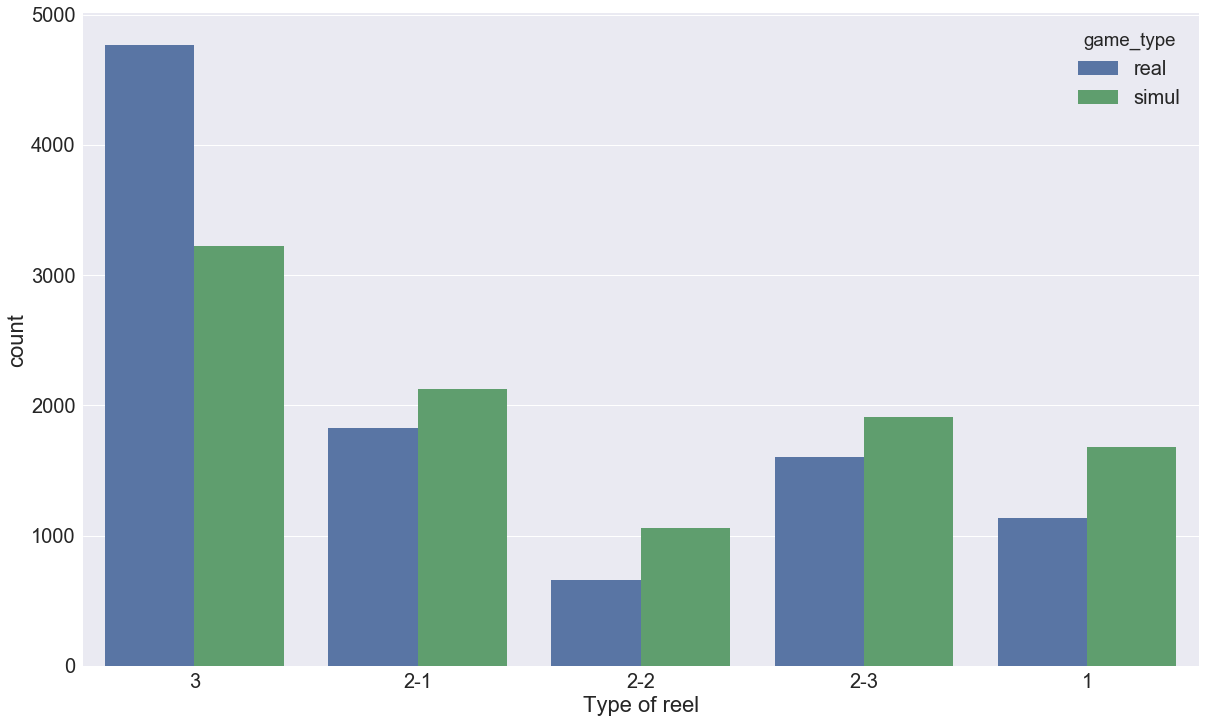

In [569]:
# 모든 reel의 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_rtype, order=['3', '2-1', '2-2', '2-3', '1'], hue='game_type')
plt.xlabel("Type of reel")
plt.show()

시각화 결과 시뮬레이션 결과와 실제 결과 사이에 큰 차이가 있음을 알 수 있습니다. 시뮬레이션의 모델처럼 모든 칸이 독립적이고 설정된 확률대로 Symbol이 등장하게 되면 한 개의 reel에서 3개가 모두 다를 확률(reel_type == 3)은 크고 (약 70%) 모두 같을 확률(reel_type == 1)은 매우 적지만 (약 1%) 실제 게임 결과에서는 3개가 모두 다를 확률은 시뮬레이션 결과보다 더 작고 모두 같을 확률은 훨씬 큰 것으로 나타납니다.

또한 2개가 같고 1개는 다른 유형에서도 다른 symbol의 위치에 따라 확률이 서로 다른 것을 확인할 수 있습니다.

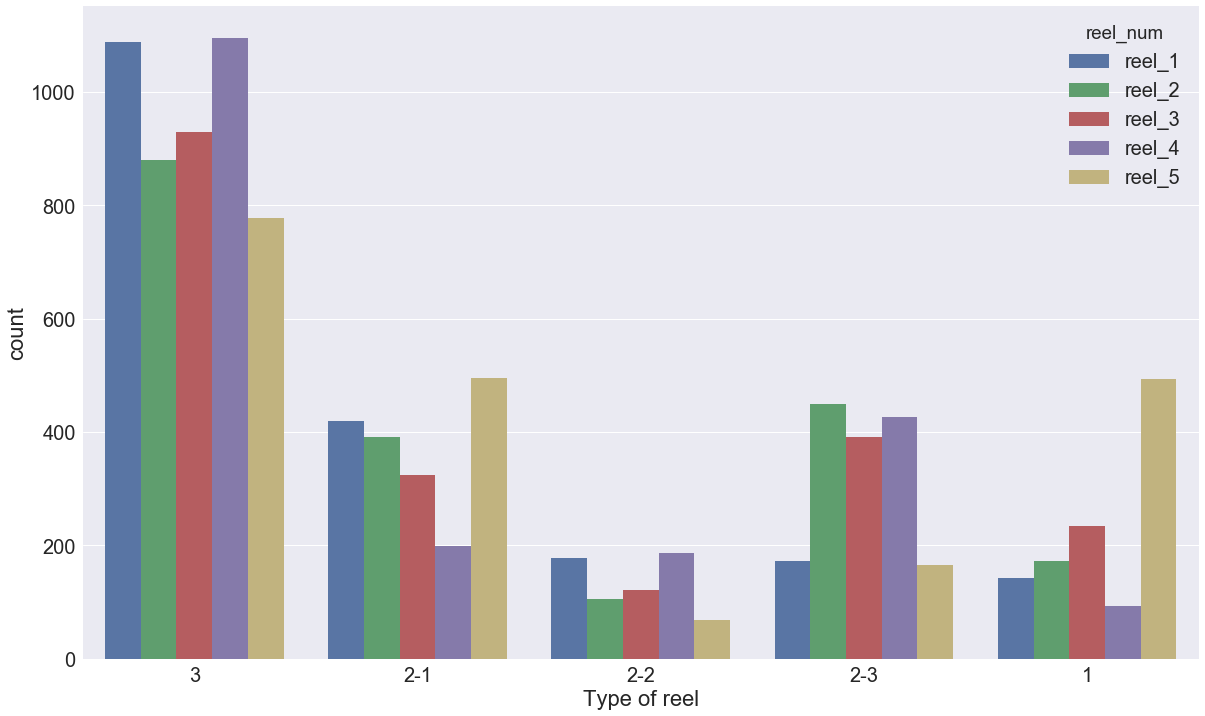

In [570]:
# 각 reel_num 별 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_rtype[df_rtype['game_type']=='real'], hue='reel_num', order=['3', '2-1', '2-2', '2-3', '1'])
plt.xlabel("Type of reel")
plt.show()

5개의 reel 별로 시각화를 한 결과 reel에 따라서도 각 유형의 확률이 다른 것을 알 수 있습니다.

따라서 게임의 모델을 보완할 때 각 reel_type의 출현 확률, 각 reel별 확률을 고려할 필요가 있음을 알 수 있습니다.

---

## 3.3 비교 - 한 번의 spin마다 등장하는 symbol의 개수 비교

In [580]:
# 실제 게임의 게임당 unique symbol의 개수를 담은 list를 생성

real_unique_count = []

for i in range(2000):
    real_unique_count.append(len(set(slot_result_per_game[i])))

In [581]:
# 가상 게임의 게임당 unique symbol의 개수를 담은 list를 생성

simul_unique_count = []

for i in range(2000):
    simul_unique_count.append(len(set(simul_result_per_game[i])))

In [582]:
real_simul_df = pd.DataFrame(columns=['classname', 'game_type'])
real_simul_df['classname'] = pd.concat([slot_result['classname'], simul_result['classname']])
real_simul_df['game_type'] = ['real'] * len(slot_result['classname']) + ['simul'] * len(simul_result['classname'])
real_simul_df = real_simul_df.reset_index(drop=True)

In [583]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_unique_count = pd.DataFrame(columns=['unique_count', 'game_type'])
df_unique_count['unique_count'] = real_unique_count + simul_unique_count
df_unique_count['game_type'] = ['real'] * len(real_unique_count) + ['simul'] * len(simul_unique_count)

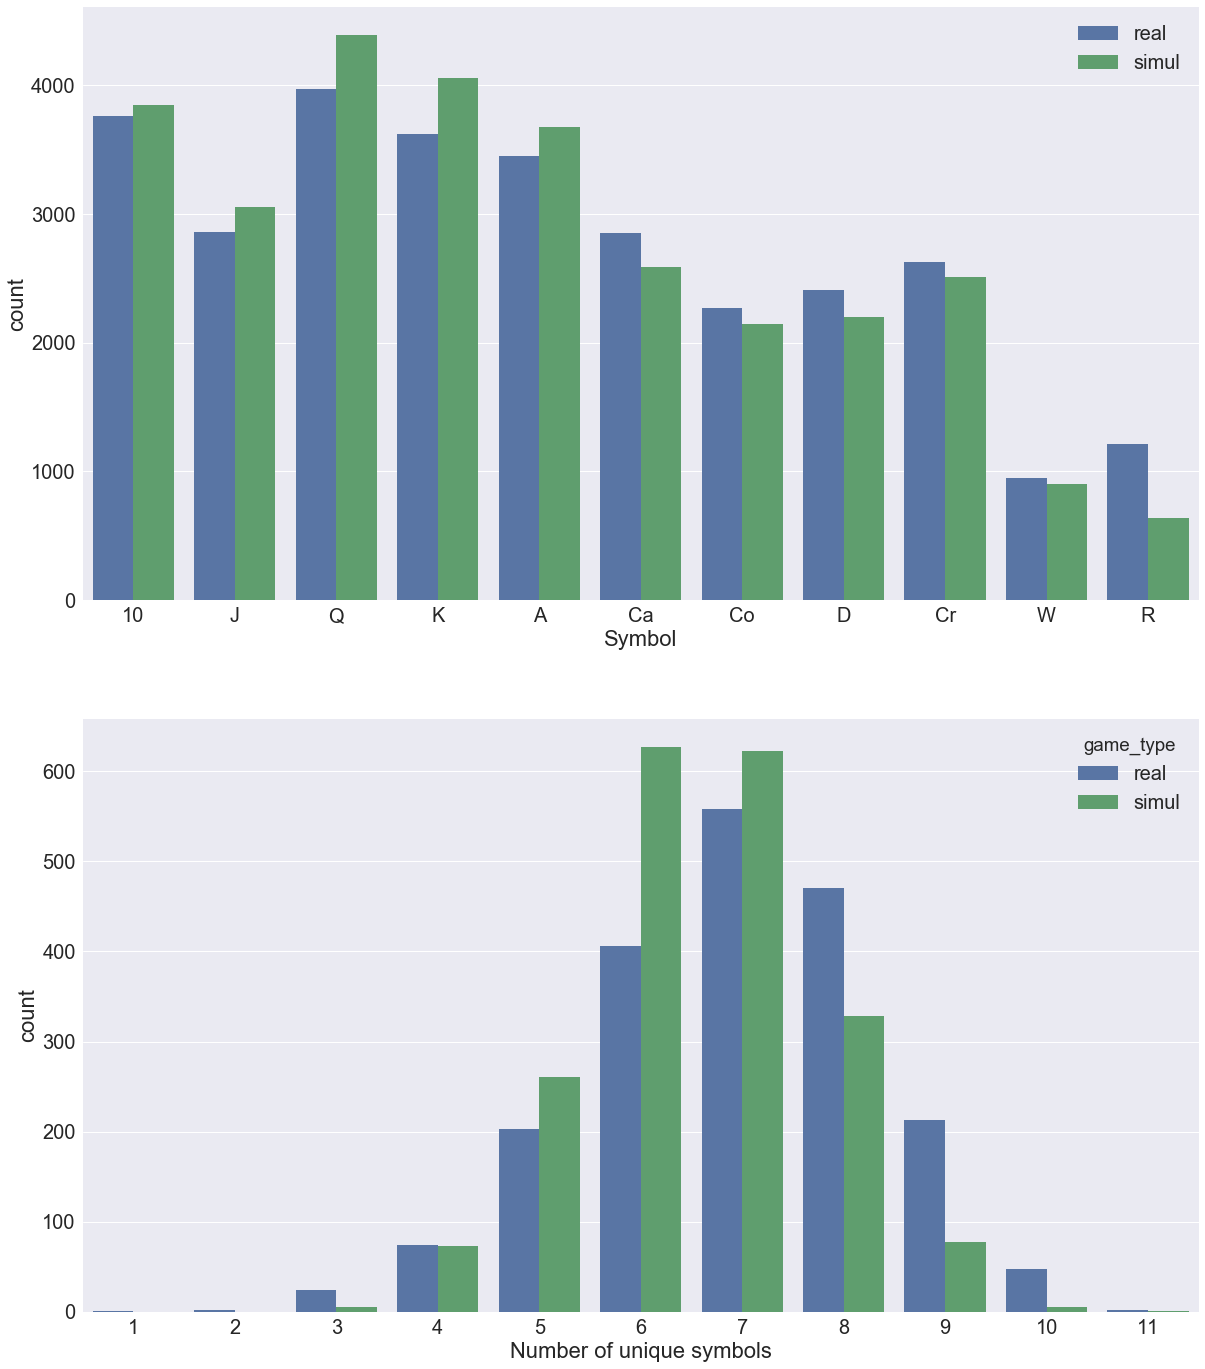

In [584]:
plt.figure(figsize=(20,24))
plt.subplot(2,1,1)
sns.countplot(x='classname', data=real_simul_df, hue='game_type', order=labels)
plt.xlabel('Symbol')

plt.legend()
plt.subplot(2,1,2)
sns.countplot(x='unique_count', data=df_unique_count, hue='game_type')
plt.xlabel('Number of unique symbols')
plt.show()

우선 각 게임의 고유한 Symbol 개수를 알아보기 전에, 실제 게임 데이터의 Symbol별 등장 확률과 가상 게임 데이터의 등장 확률이 같은 지를 확인해보겠습니다. 이 차이가 유의한지 여부를 확인하기 위해 카이제곱 적합도 검정을 사용합니다.

###### Hypothesis test 3

귀무 가설과 대립 가설은 아래와 같습니다.

* H<sub>0</sub>: 시뮬레이션 결과는 실제 결과와 같다
* H<sub>1</sub>: 시뮬레이션 결과는 실제 결과와 다르다

테스트는 5% 유의 수준에서 수행되었습니다.

In [551]:
f_obs = list(slot_result['classname'].value_counts().sort_index())
f_exp = list(simul_result['classname'].value_counts().sort_index())

st.chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=662.6008183035746, pvalue=6.668012537151091e-136)

p-value가 0.057로 유의수준 0.05보다 큰 값이므로 귀무가설을 지지합니다. 이처럼 실제 결과와 시뮬레이션 결과의 Symbol 등장 횟수는 차이가 없다고 볼 수 있지만 두번째 시각화 그래프를 보면 가상 게임 데이터는 실제 게임 데이터에 비해 오른쪽으로 치우쳐있는 것을 볼 수 있습니다.
즉 위의 2개의 그래프는 실제 게임에서는 시뮬레이션 게임에 비에서 Symbol이 같은 것끼리 몰아서 나오는 경향을 가지고 있다는 것을 의미합니다.

---

## 3-4 비교 - reward를 획득한 payline의 길이

In [552]:
def getSym(lst):
    if len(set(lst)) < 2:
        return lst[0]
    else:
        for x in list(set(lst)):
            if x != 'W':
                return x
            else:
                continue

def richCheck(game, bpl):
    rnum = game.count('R')
    if rnum <= 2:
        return 0
    elif rnum == 3:
        return bpl * 30
    elif rnum == 4:
        return bpl * 90
    elif rnum == 5:
        return bpl * 240
    elif rnum == 6:
        return bpl * 900
    elif rnum == 7:
        return bpl * 2250
    elif rnum == 8:
        return bpl * 15000
    elif rnum == 9:
        return bpl * 30000

def calPlatinumPayline(game, bpl):
    pay = 0
    r_acc = 0
    pay_type_list = []
    
    # RICH 보너스 계산
    pay += richCheck(game, bpl)
    r_acc += game.count('R')
    
    '''
    # RICH 누적 보너스 계산
    if r_acc >= 100:
        r_acc = 0
        # pay += bpl *  
    '''
    
    # payline 계산
    for payline in paylines:
        tmp = []
        for i in range(5):
            if i == 4:
                tmp.append(game[payline[i]])
                break
            if i == 0 and game[payline[i]] == 'W':
                tmp.append(game[payline[i]])
            elif game[payline[i]] != game[payline[i+1]] and game[payline[i+1]] != 'W':
                tmp.append(game[payline[i]])
                break
            else:
                tmp.append(game[payline[i]])
        if len(tmp) <= 2:
            tmp = []
        else:
            sym = getSym(tmp)
            pay += payTable.loc[len(tmp)-3, sym] * bpl
        pay_type_list.append(tmp)
    return pay, pay_type_list

def playPlatinum(n, bpl):
    pay_list = []
    pay_type_list = []
    while(n):
        game = spin_platinum()
        pay_list.append(calPlatinumPayline(game, bpl)[0])
        pay_type_list.append(calPlatinumPayline(game, bpl)[1])
        n -= 1
    return pay_list, pay_type_list

In [553]:
real_pay_list, real_pay_type_list = [], []
for real_game in slot_result_per_game:
    real_pay_list.append(calPlatinumPayline(real_game, 2000)[0])
    real_pay_type_list.append(calPlatinumPayline(real_game, 2000)[1])
simul_pay_list, simul_pay_type_list = playPlatinum(2000, 2000)

In [510]:
print('Simulation Average Reward : ', sum(simul_pay_list) / len(simul_pay_list))
print('Real Average Reward : ', sum(real_pay_list) / len(real_pay_list))

Simulation Average Reward :  6732.0
Real Average Reward :  34503.0
